
Running scenario: Base
[10.29] Patient 1 (gender=male) arrives.
[23.05] Patient 2 (gender=female) arrives.
[34.61] Patient 3 (gender=female) arrives.
[40.82] Patient 4 (gender=male) arrives.
[47.81] Patient 5 (gender=male) arrives.
[69.62] Patient 6 (gender=female) arrives.
[74.43] Patient 7 (gender=male) arrives.
[78.18] Patient 8 (gender=female) arrives.
[79.32] Patient 9 (gender=male) arrives.
[82.29] Patient 1 discharged from Bay 0.
[83.32] Patient 9 admitted after waiting 4.0h.
[83.89] Patient 10 (gender=male) arrives.
[92.80] Patient 11 (gender=female) arrives.
[93.38] Patient 12 (gender=female) arrives.
[94.57] Patient 13 (gender=female) arrives.
[95.05] Patient 2 discharged from Bay 1.
[96.80] Patient 11 admitted after waiting 4.0h.
[98.10] Patient 14 (gender=male) arrives.
[105.07] Patient 15 (gender=female) arrives.
[106.61] Patient 3 discharged from Bay 1.
[109.07] Patient 15 admitted after waiting 4.0h.
[112.82] Patient 4 discharged from Bay 0.
[113.38] Patient 12 admitted

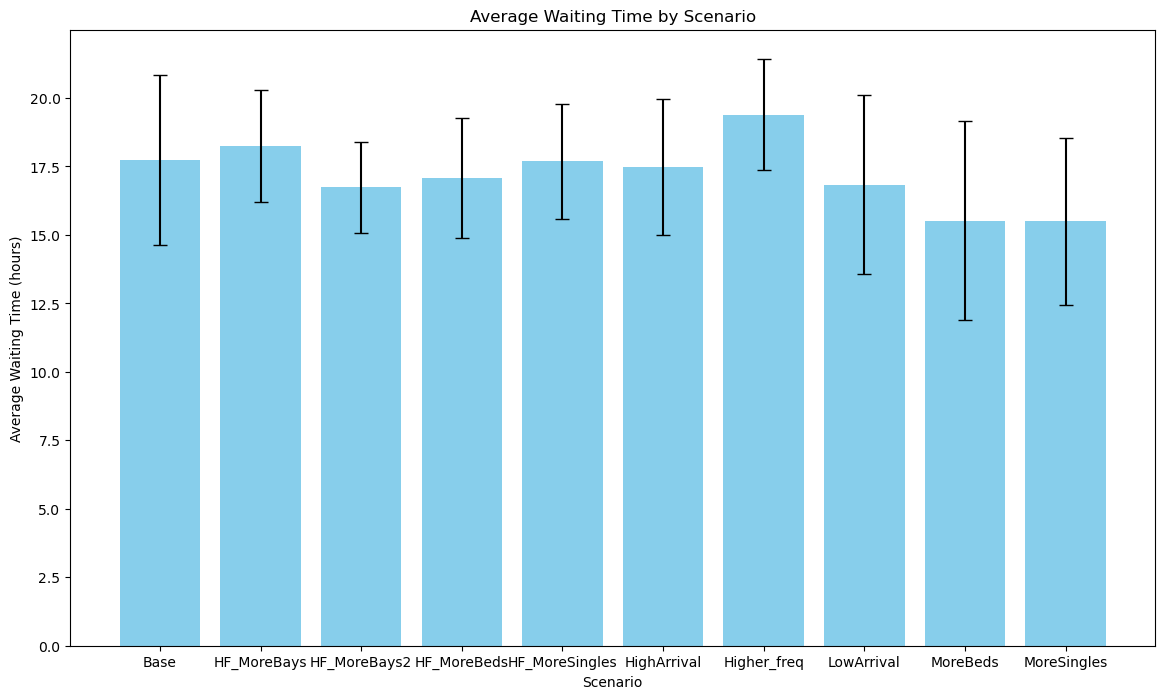

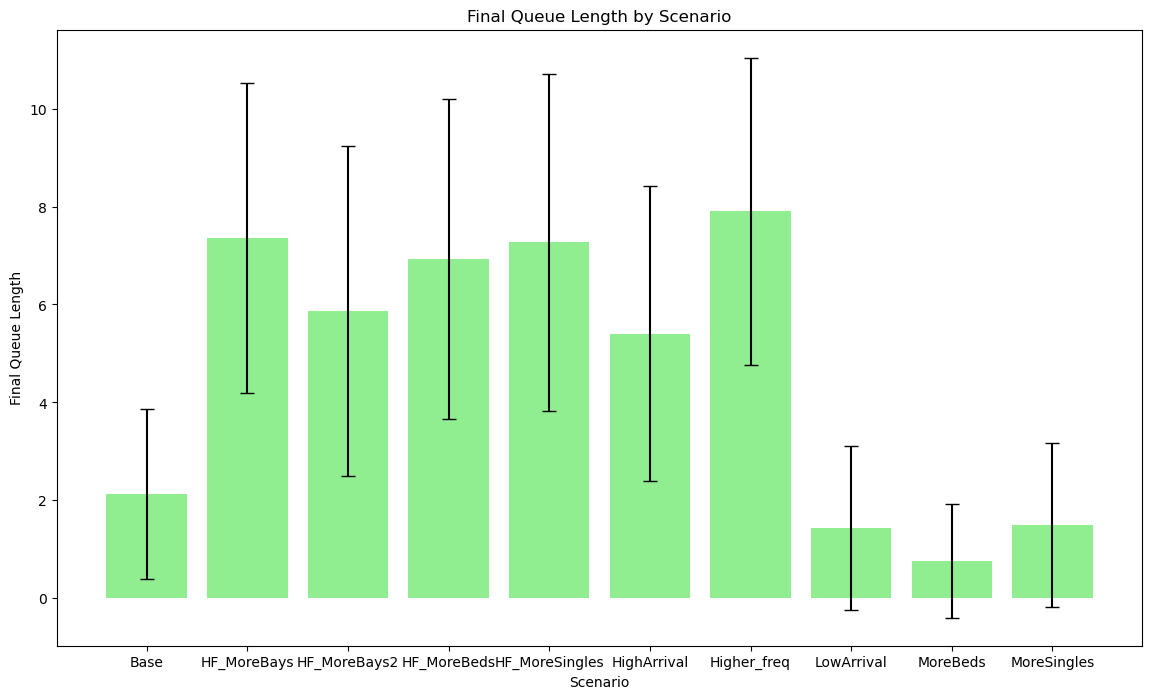

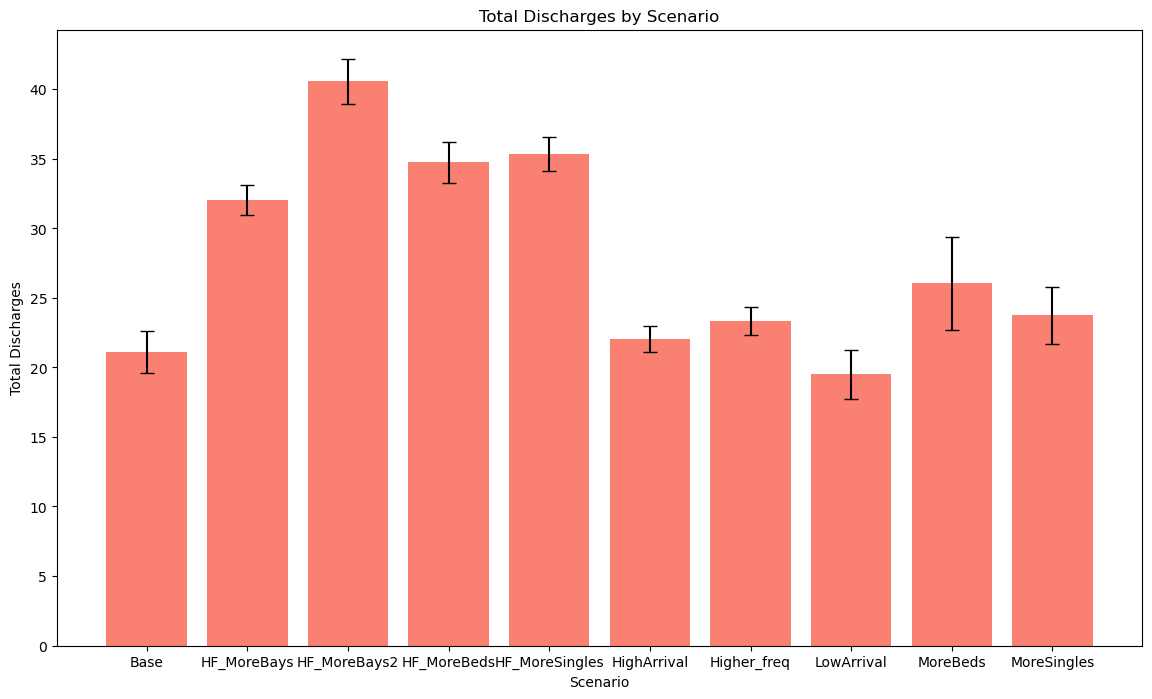

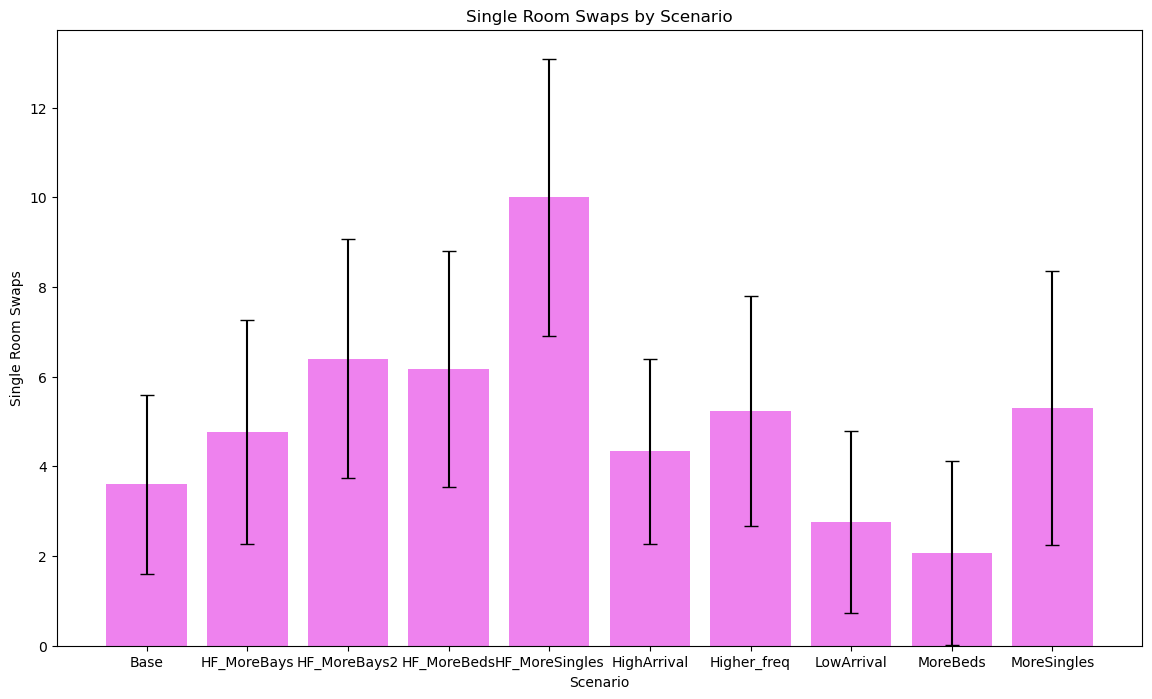


Results saved to 'simulation_results.csv'.


In [5]:
# This could be amended using LLM to have different the 5 different groups all with different LoS, split by gender...


import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Optional

# ==============================================================================
# Section 1: Data Structures and Core Classes
# ==============================================================================

@dataclass
class Patient:
    pid: int
    arrival_time: float
    gender: str        # 'male' or 'female'
    group: str         # e.g., "Group1"
    los_hours: float   # Length of stay in hours
    max_wait: float    # Maximum waiting time before leaving (hours)
    waiting_time: float = 0.0
    bed_allocated: bool = False

class WardBay:
    """
    Represents a multi-bed bay that becomes single-sex once occupied.
    """
    def __init__(self, bay_id: int, capacity: int):
        self.bay_id = bay_id
        self.capacity = capacity
        self.current_gender: Optional[str] = None
        self.patients: List[Patient] = []
    
    def can_accept(self, p: Patient) -> bool:
        if len(self.patients) >= self.capacity:
            return False
        return (self.current_gender is None) or (self.current_gender == p.gender)
    
    def add_patient(self, p: Patient):
        self.patients.append(p)
        if self.current_gender is None:
            self.current_gender = p.gender
    
    def remove_patient(self, p: Patient):
        if p in self.patients:
            self.patients.remove(p)
        if len(self.patients) == 0:
            self.current_gender = None

    @property
    def n_occupied(self):
        return len(self.patients)
    
    @property
    def n_free(self):
        return self.capacity - len(self.patients)

class HospitalWard:
    """
    Manages multiple bays and single rooms.
    Implements the single-sex allocation logic and collects performance metrics.
    """
    def __init__(self, env: simpy.Environment, num_bays: int, beds_per_bay: int, num_singles: int):
        self.env = env
        self.bays: List[WardBay] = [WardBay(bay_id=i, capacity=beds_per_bay) for i in range(num_bays)]
        self.single_rooms: List[Optional[Patient]] = [None] * num_singles
        self.wait_queue: List[Patient] = []
        self.wait_times: Dict[int, float] = {}  # patient id : waiting time
        self.single_room_swaps: int = 0
        self.total_discharges: int = 0

    def try_allocate(self, p: Patient, allow_shuffle: bool = True) -> bool:
        # Step 1: Try to allocate in a bay with same gender.
        same_gender_bays = [bay for bay in self.bays if bay.can_accept(p) and bay.current_gender == p.gender]
        if same_gender_bays:
            bay = max(same_gender_bays, key=lambda b: b.n_occupied / b.capacity)
            bay.add_patient(p)
            p.bed_allocated = True
            return True

        # Step 2: Try to allocate in an empty bay.
        empty_bays = [bay for bay in self.bays if bay.can_accept(p) and bay.current_gender is None]
        if empty_bays:
            bay = empty_bays[0]
            bay.add_patient(p)
            p.bed_allocated = True
            return True

        # Step 3: Try to allocate to a single room.
        for i in range(len(self.single_rooms)):
            if self.single_rooms[i] is None:
                self.single_rooms[i] = p
                p.bed_allocated = True
                return True

        # Step 4: Attempt to free a single room by shuffling out an occupant of opposite gender.
        if allow_shuffle:  # Only attempt shuffling if allowed
            for i in range(len(self.single_rooms)):
                occupant = self.single_rooms[i]
                if occupant is not None and occupant.gender != p.gender:
                    occupant.bed_allocated = False
                    # Try to allocate occupant without further shuffling.
                    if self.try_allocate(occupant, allow_shuffle=False):
                        self.single_rooms[i] = p
                        p.bed_allocated = True
                        self.single_room_swaps += 1
                        return True
                    else:
                        occupant.bed_allocated = True
        # Step 5: Allocation failed.
        return False

# ==============================================================================
# Section 2: Simulation Processes
# ==============================================================================

def patient_generator(env, ward: HospitalWard, group_name: str,
                      mean_iat: float, los_days: float, gender_prob: float,
                      max_wait_hours: float, rng_seed: int = 42):
    """
    Generates patients using an exponential interarrival time.
    """
    rng = np.random.default_rng(rng_seed)
    pid_count = 0
    while True:
        iat = rng.exponential(mean_iat)
        yield env.timeout(iat)
        pid_count += 1
        arrival_time = env.now
        gender = 'female' if rng.random() < gender_prob else 'male'
        los_hours = los_days * 24.0
        patient = Patient(pid=pid_count, arrival_time=arrival_time,
                          gender=gender, group=group_name,
                          los_hours=los_hours, max_wait=max_wait_hours)
        print(f"[{env.now:.2f}] Patient {patient.pid} (gender={patient.gender}) arrives.")
        allocated = ward.try_allocate(patient)
        if allocated:
            env.process(treatment_process(env, ward, patient))
        else:
            patient.waiting_time = env.now
            ward.wait_queue.append(patient)
            env.process(wait_in_queue(env, ward, patient))

def wait_in_queue(env, ward: HospitalWard, p: Patient):
    """
    If initial allocation fails, reattempt allocation after a short wait.
    Patient leaves if maximum waiting time is exceeded.
    """
    recheck_interval = 4.0  # hours
    start_wait = env.now
    while True:
        yield env.timeout(recheck_interval)
        if p not in ward.wait_queue:
            return
        if (env.now - start_wait) > p.max_wait:
            ward.wait_queue.remove(p)
            print(f"[{env.now:.2f}] Patient {p.pid} left after waiting {env.now - start_wait:.1f}h.")
            return
        allocated = ward.try_allocate(p)
        if allocated:
            ward.wait_queue.remove(p)
            total_wait = env.now - start_wait
            ward.wait_times[p.pid] = total_wait
            print(f"[{env.now:.2f}] Patient {p.pid} admitted after waiting {total_wait:.1f}h.")
            env.process(treatment_process(env, ward, p))
            return

def treatment_process(env, ward: HospitalWard, p: Patient):
    """
    Simulates the patient’s stay on the ward.
    Optionally, subtract a fraction of waiting time from the length of stay.
    """
    # Uncomment the following to subtract waiting time fraction (e.g., 50%):
    # waited = ward.wait_times.get(p.pid, 0.0)
    # p.los_hours = max(p.los_hours - 0.5 * waited, 0.0)
    yield env.timeout(p.los_hours)
    discharge_patient(ward, p, env.now)

def discharge_patient(ward: HospitalWard, p: Patient, current_time: float):
    """
    Discharges the patient from the ward and increments the discharge counter.
    """
    for bay in ward.bays:
        if p in bay.patients:
            bay.remove_patient(p)
            ward.total_discharges += 1
            print(f"[{current_time:.2f}] Patient {p.pid} discharged from Bay {bay.bay_id}.")
            return
    for i, occupant in enumerate(ward.single_rooms):
        if occupant == p:
            ward.single_rooms[i] = None
            ward.total_discharges += 1
            print(f"[{current_time:.2f}] Patient {p.pid} discharged from Single Room {i}.")
            return

# ==============================================================================
# Section 3: Simulation and Replication Functions (with Custom Parameters)
# ==============================================================================

def run_simulation(replication_time: float, seed: int,
                   mean_iat: float, los_days: float, gender_prob: float,
                   max_wait_hours: float, num_bays: int, beds_per_bay: int, num_singles: int) -> Dict:
    """
    Runs a single replication of the simulation with the given parameters.
    Returns key performance metrics.
    """
    env = simpy.Environment()
    ward = HospitalWard(env, num_bays=num_bays, beds_per_bay=beds_per_bay, num_singles=num_singles)
    env.process(patient_generator(env, ward, group_name="Group1",
                                  mean_iat=mean_iat,
                                  los_days=los_days,
                                  gender_prob=gender_prob,
                                  max_wait_hours=max_wait_hours,
                                  rng_seed=seed))
    env.run(until=replication_time)
    avg_wait = np.mean(list(ward.wait_times.values())) if ward.wait_times else 0.0
    max_wait = np.max(list(ward.wait_times.values())) if ward.wait_times else 0.0
    metrics = {
        "FinalQueueLength": len(ward.wait_queue),
        "AverageWaitingTime": avg_wait,
        "MaxWaitingTime": max_wait,
        "TotalDischarges": ward.total_discharges,
        "SingleRoomSwaps": ward.single_room_swaps,
        "SimulationTime": replication_time
    }
    return metrics

def run_replications(num_replications: int, replication_time: float,
                     mean_iat: float, los_days: float, gender_prob: float,
                     max_wait_hours: float, num_bays: int, beds_per_bay: int, num_singles: int) -> pd.DataFrame:
    """
    Runs multiple replications for a given scenario and returns a DataFrame of metrics.
    """
    all_metrics = []
    for rep in range(num_replications):
        seed = 1000 + rep  # Unique seed for each replication.
        metrics = run_simulation(replication_time, seed,
                                 mean_iat, los_days, gender_prob,
                                 max_wait_hours, num_bays, beds_per_bay, num_singles)
        metrics["Replication"] = rep + 1
        all_metrics.append(metrics)
    df = pd.DataFrame(all_metrics)
    return df

# ==============================================================================
# Section 4: Running Multiple Scenarios and Visualizing Results
# ==============================================================================

def run_scenarios():
    # Define a list of scenarios with different parameters.
    scenarios = [
        {"scenario_id": "Base", "mean_iat": 8.0, "los_days": 3.0, "num_bays": 2, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HighArrival", "mean_iat": 6.0, "los_days": 3.0, "num_bays": 2, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "LowArrival", "mean_iat": 10.0, "los_days": 3.0, "num_bays": 2, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "MoreBeds", "mean_iat": 8.0, "los_days": 3.0, "num_bays": 3, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "MoreSingles", "mean_iat": 8.0, "los_days": 3.0, "num_bays": 2, "beds_per_bay": 3, "num_singles": 2, "max_wait_hours": 36.0},
        {"scenario_id": "Higher_freq", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 2, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HF_MoreBeds", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 2, "beds_per_bay": 5, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HF_MoreBays", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 3, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HF_MoreBays2", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 4, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HF_MoreSingles", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 2, "beds_per_bay": 3, "num_singles": 5, "max_wait_hours": 36.0}
    ]

    # Scenarios:
    # Higher_freq - Higher frequency of arrivals has marked impact on the average waiting time and the final queue at the end
    # HF_MoreBeds - beds has been amended to work out how many more beds are needed to bring the waiting time down to the base level compared with the Higher Frequency scenario
    # To reduce the waiting time, need to increase the beds per bays to 5, which gives a total of 10 beds (2x5)
    # Can this be achieved in another way - by increasing the number of bays?  yes, but need to increase the number of bays to 4.  This gives a total of 12 beds (4x3)
    # however, although these changes to mitigate the increase in admittance rate can reduce the waiting time, it still leaves a much higher final queue.  The discharge total is much higher (presumably meaning more people seen overall)
    # Can more single beds help with managing a faster admittance rate?  Yes - according to scenario HF_MoreSingles but need to increase it by quite a lot, up to 5.
    # With above scenario, final queue is still high, but total discharge is high
    # Of these scenarios, more bays seems to support the increased rate of admittance best, giving a reduced waiting time, comparable with the base, and also high total discharge 

    
    
    replication_time = 300  # hours per replication (200 is base)
    num_replications = 30   # replications per scenario (20 is base)
    
    scenario_results = []
    
    for scen in scenarios:
        print(f"\nRunning scenario: {scen['scenario_id']}")
        df = run_replications(num_replications, replication_time,
                              mean_iat=scen["mean_iat"],
                              los_days=scen["los_days"],
                              gender_prob=0.5,  # fixed for all scenarios
                              max_wait_hours=scen["max_wait_hours"],
                              num_bays=scen["num_bays"],
                              beds_per_bay=scen["beds_per_bay"],
                              num_singles=scen["num_singles"])
        # Add scenario identifier to each row.
        df["Scenario"] = scen["scenario_id"]
        scenario_results.append(df)
    
    all_results = pd.concat(scenario_results, ignore_index=True)
    return all_results

def visualize_scenario_results(df: pd.DataFrame):
    """
    Generates visualizations comparing scenarios.
    """
    # Summary: average waiting time per scenario.
    summary = df.groupby("Scenario").agg({
        "AverageWaitingTime": ["mean", "std"],
        "FinalQueueLength": ["mean", "std"],
        "TotalDischarges": ["mean", "std"],
        "SingleRoomSwaps": ["mean", "std"]
    })
    summary.columns = ["_".join(col).strip() for col in summary.columns.values]
    summary.reset_index(inplace=True)
    print("\n--- Summary Statistics per Scenario ---")
    print(summary.to_string(index=False))
    
    # Bar chart: Average Waiting Time per Scenario
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["AverageWaitingTime_mean"], yerr=summary["AverageWaitingTime_std"],
            capsize=5, color="skyblue")
    plt.xlabel("Scenario")
    plt.ylabel("Average Waiting Time (hours)")
    plt.title("Average Waiting Time by Scenario")
    plt.show()
    
    # Bar chart: Final Queue Length per Scenario
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["FinalQueueLength_mean"], yerr=summary["FinalQueueLength_std"],
            capsize=5, color="lightgreen")
    plt.xlabel("Scenario")
    plt.ylabel("Final Queue Length")
    plt.title("Final Queue Length by Scenario")
    plt.show()
    
    # Bar chart: Total Discharges per Scenario
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["TotalDischarges_mean"], yerr=summary["TotalDischarges_std"],
            capsize=5, color="salmon")
    plt.xlabel("Scenario")
    plt.ylabel("Total Discharges")
    plt.title("Total Discharges by Scenario")
    plt.show()
    
    # Bar chart: Single Room Swaps per Scenario
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["SingleRoomSwaps_mean"], yerr=summary["SingleRoomSwaps_std"],
            capsize=5, color="violet")
    plt.xlabel("Scenario")
    plt.ylabel("Single Room Swaps")
    plt.title("Single Room Swaps by Scenario")
    plt.show()

# ==============================================================================
# Section 5: Main Execution
# ==============================================================================

def main():
    # Run all scenarios.
    results_df = run_scenarios()
    
    # Print raw results (each replication).
    print("\n--- Raw Simulation Results ---")
    print(results_df.to_string(index=False))
    
    # Visualize summary and scenario comparisons.
    visualize_scenario_results(results_df)
    
    # Save results to CSV (optional, for report inclusion).
    results_df.to_csv("simulation_results.csv", index=False)
    print("\nResults saved to 'simulation_results.csv'.")

if __name__ == '__main__':
    main()